<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Teste_de_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [27]:
#@title Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')
data_dir_human_silhouettes = "gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset"
data_dir_fine_tunning = "gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning"
data_dir_mask_images = "gdrive/MyDrive/Projeto/data/processed/mask_images"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
#@title Python Imports
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode



# Neptune config

In [3]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.2 MB/s eta 0:00:00


### Pickle

A partir das funções a seguir, foi possível selecionar os modelos de rede de melhor performance.

In [4]:
#@title Neptune Pickle Functions
import neptune.new as neptune
from neptune.types import File
import pickle

def neptune_start_ID(with_id='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',
                       with_id=with_id,
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run

def neptune_download_pickle():
    run["model/pickled_model"].download(destination="./model.pkl")
    file = open("/content/model.pkl",'rb')
    model = pickle.load(file)
    return model

/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-631e2b4445e4>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


Os modelos selecionados são os equivalentes ao modelo treinado do EfficientNet-B2 e à versão com fine tunning.

In [5]:
#@title Models Loaders
run = neptune_start_ID("IA90-148")
print(run["sys/id"].fetch())
model_efficientnet_b2 = neptune_download_pickle()

run.stop()

run = neptune_start_ID("IA90-188")
model_fine_tunning = neptune_download_pickle()

<ipython-input-4-631e2b4445e4>:6: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run (project= 'octavioguaschi/IA901-218390',


https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-148
IA90-148
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-148/metadata
https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-188


# Dataset Loader


In [6]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [29]:
#@title Transforms and Dataloaders

# mean and standard deviation for normalization
def normilize_attributes(dataset):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )

    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_samples = len(dataset)

    for inputs, _ in loader:
        mean += torch.mean(inputs, dim=(0, 2, 3))
        std += torch.std(inputs, dim=(0, 2, 3))

    mean /= num_samples
    std /= num_samples

    return mean.tolist(), std.tolist()

dataset_for_normalize = datasets.ImageFolder('gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/train', transform=None)

# Data transform for testing
normalize_transform = transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ColorJitter(brightness=0.2, contrast=0., saturation=0., hue=0.),
        transforms.RandomPerspective(distortion_scale=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomEqualize(p=0.5),
        transforms.RandomInvert(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
])

dataset_for_normalize.transform = normalize_transform

mean, std = normilize_attributes(dataset_for_normalize)

# Data transform for testing
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

# Data transform and normalization for testing
data_transforms_fine_tunning = {
    'test': transforms.Compose([
        normalize_transform,
        transforms.Normalize(mean=mean, std=std)
    ])
}

# Datasets for test
image_datasets_human_silhouettes = ImageFolderWithPath(os.path.join(data_dir_human_silhouettes, 'test'), data_transforms['test'])
image_datasets_fine_tunning = ImageFolderWithPath(os.path.join(data_dir_fine_tunning, 'test'), data_transforms_fine_tunning['test'])
image_datasets_mask_images = ImageFolderWithPath(os.path.join(data_dir_mask_images, 'test'), data_transforms['test'])

# Dataloaders for test
dataloaders_human_silhouettes = torch.utils.data.DataLoader(image_datasets_human_silhouettes, batch_size=32, shuffle=True, num_workers=2)
dataloaders_fine_tunning = torch.utils.data.DataLoader(image_datasets_fine_tunning, batch_size=32, shuffle=True, num_workers=2)
dataloaders_mask_images = torch.utils.data.DataLoader(image_datasets_mask_images, batch_size=32, shuffle=True, num_workers=2)

dataset_sizes_human_silhouettes = len(image_datasets_human_silhouettes)
dataset_sizes_fine_tunning = len(image_datasets_fine_tunning)
dataset_sizes_mask_images = len(image_datasets_mask_images)

class_names_human_silhouettes = image_datasets_human_silhouettes.classes
class_names_fine_tunning = image_datasets_fine_tunning.classes
class_names_mask_images = image_datasets_mask_images.classes

# Seed lock for reprodutibility
seed = 2809

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
print(dataset_sizes_human_silhouettes)
print(dataset_sizes_fine_tunning)
print(dataset_sizes_mask_images)

print(class_names_human_silhouettes)
print(class_names_fine_tunning)
print(class_names_mask_images)

723
51
51
['lying', 'sitting', 'standing']
['lying', 'sitting', 'standing']
['lying', 'sitting', 'standing']


In [15]:
# Visualize on test
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Testing Model

In [23]:
#@title Test Function
def test_model(model, dataloaders, class_names, num_images=51):
    was_training = model.training
    model.eval()
    images_so_far = 0
    certos = 0
    errados = 0

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if(paths[j].split('/')[7] != class_names[preds[j]]):
                  images_so_far += 1
                  errados += 1
                  fig = plt.figure(figsize=(50, 50))
                  plt.tight_layout()
                  plt.subplot(num_images, 1, images_so_far)
                  plt.axis('off')
                  print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                  run['test/predicted'].append('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                  imshow(inputs.cpu().data[j])
                else:
                  certos +=1
                  images_so_far += 1
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print('Test Acc: {:4f}'.format(certos/(certos+errados)))
                    run['test/acc'].append(certos/(certos+errados))
                    return
        model.train(mode=was_training)

path: sitting / predicted: standing


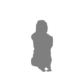

path: lying / predicted: standing


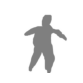

path: sitting / predicted: standing


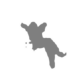

Test Acc: 0.941176


In [24]:
#@title Test Human Silhouettes dataset on trained model (no fine tunning)
test_model(model_efficientnet_b2, dataloaders_human_silhouettes, class_names_human_silhouettes)

path: sitting / predicted: lying


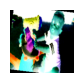

path: sitting / predicted: lying


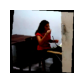

path: sitting / predicted: standing


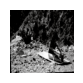

path: lying / predicted: sitting


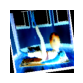

path: lying / predicted: sitting


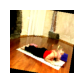

path: standing / predicted: lying


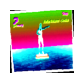

path: lying / predicted: sitting


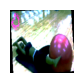

path: standing / predicted: lying


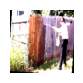

path: sitting / predicted: lying


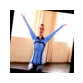

path: standing / predicted: sitting


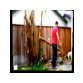

path: standing / predicted: sitting


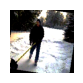

path: sitting / predicted: lying


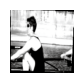

path: standing / predicted: lying


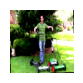

path: lying / predicted: sitting


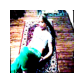

path: standing / predicted: sitting


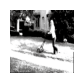

path: standing / predicted: lying


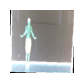

path: lying / predicted: sitting


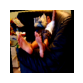

path: standing / predicted: sitting


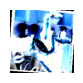

path: lying / predicted: sitting


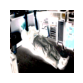

path: lying / predicted: standing


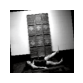

path: standing / predicted: lying


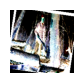

path: standing / predicted: lying


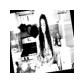

path: standing / predicted: lying


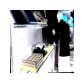

path: sitting / predicted: lying


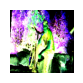

path: sitting / predicted: lying


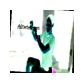

path: sitting / predicted: lying


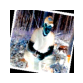

path: standing / predicted: lying


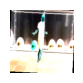

path: sitting / predicted: lying


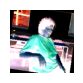

path: standing / predicted: sitting


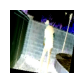

path: sitting / predicted: lying


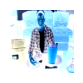

path: sitting / predicted: lying


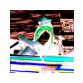

path: sitting / predicted: standing


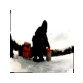

path: standing / predicted: sitting


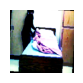

Test Acc: 0.352941


In [25]:
#@title Test MPII dataset on trained model (no fine tunning)
test_model(model_efficientnet_b2, dataloaders_fine_tunning, class_names_fine_tunning)

path: lying / predicted: sitting


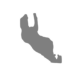

path: sitting / predicted: standing


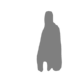

path: sitting / predicted: standing


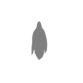

path: lying / predicted: sitting


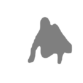

path: lying / predicted: sitting


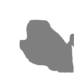

path: sitting / predicted: standing


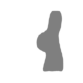

path: lying / predicted: sitting


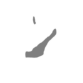

path: sitting / predicted: standing


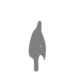

path: sitting / predicted: standing


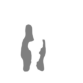

path: sitting / predicted: standing


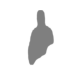

path: lying / predicted: sitting


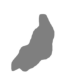

path: lying / predicted: sitting


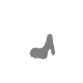

path: sitting / predicted: standing


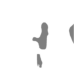

path: sitting / predicted: standing


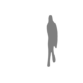

path: lying / predicted: sitting


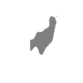

path: sitting / predicted: standing


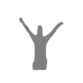

path: sitting / predicted: standing


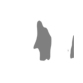

Test Acc: 0.666667


In [32]:
#@title Test COCO dataset, with mask and segmentation, on trained model (no fine tunning)
test_model(model_efficientnet_b2, dataloaders_mask_images, class_names_mask_images)

path: sitting / predicted: standing


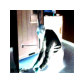

path: sitting / predicted: lying


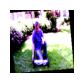

path: standing / predicted: sitting


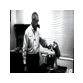

path: standing / predicted: lying


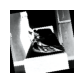

path: standing / predicted: sitting


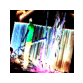

path: lying / predicted: sitting


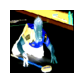

path: lying / predicted: sitting


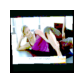

path: sitting / predicted: standing


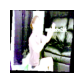

path: sitting / predicted: lying


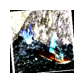

path: lying / predicted: sitting


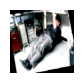

path: sitting / predicted: standing


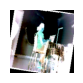

path: sitting / predicted: lying


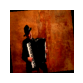

path: lying / predicted: sitting


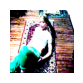

path: lying / predicted: sitting


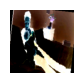

path: sitting / predicted: standing


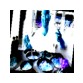

path: sitting / predicted: standing


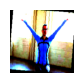

Test Acc: 0.686275


In [31]:
#@title Test MPII dataset on fine tunned model
test_model(model_fine_tunning, dataloaders_fine_tunning, class_names_fine_tunning)